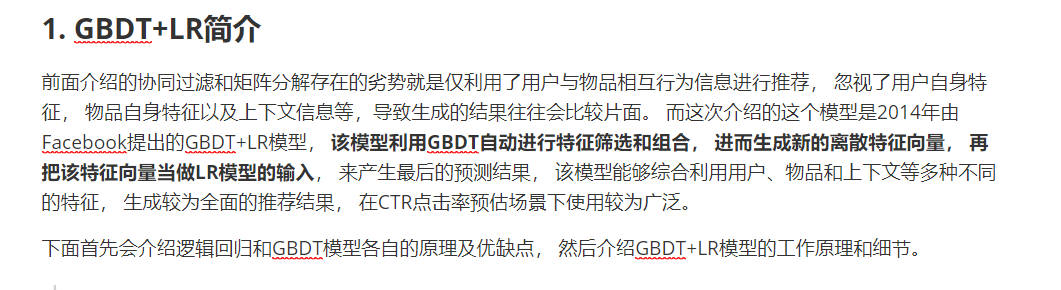

###  LR模型的不足之处

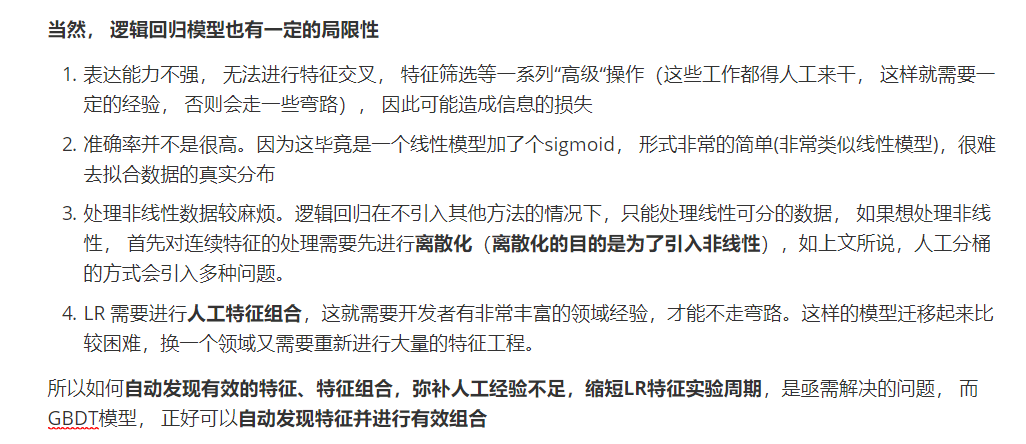

###  GBDT 的数学推导过程，太难了。。以后有时间再看吧！。。。

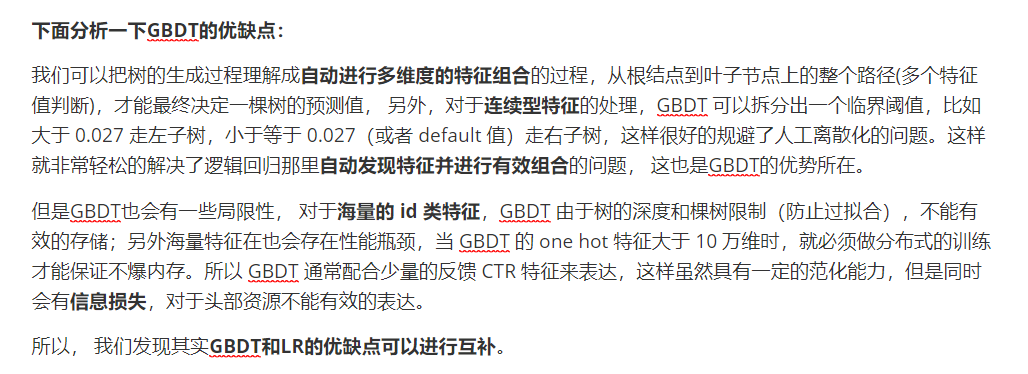

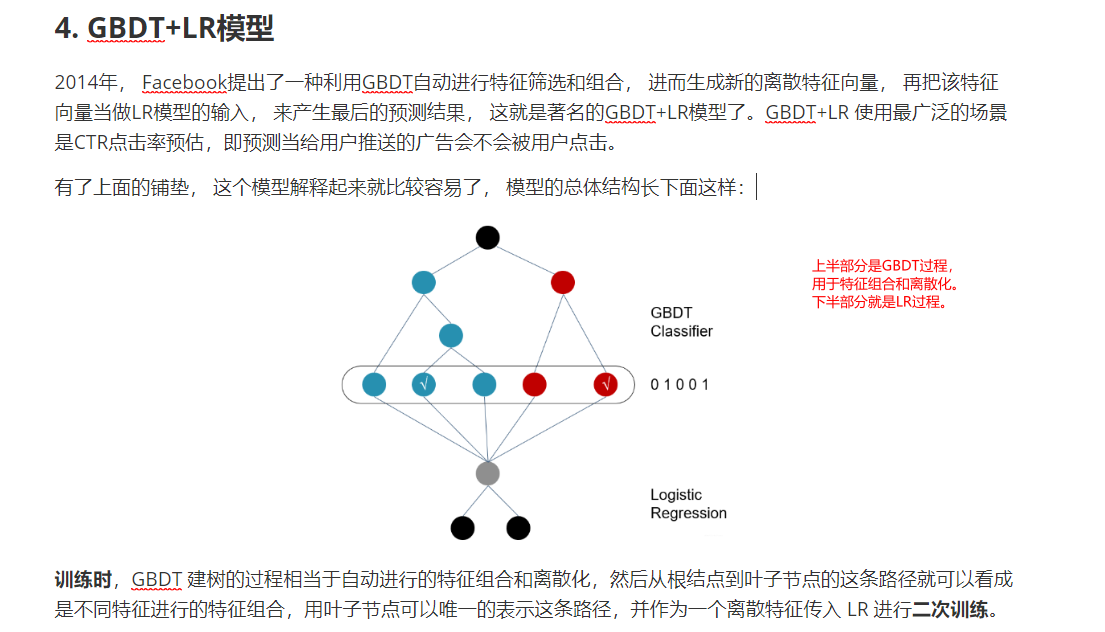

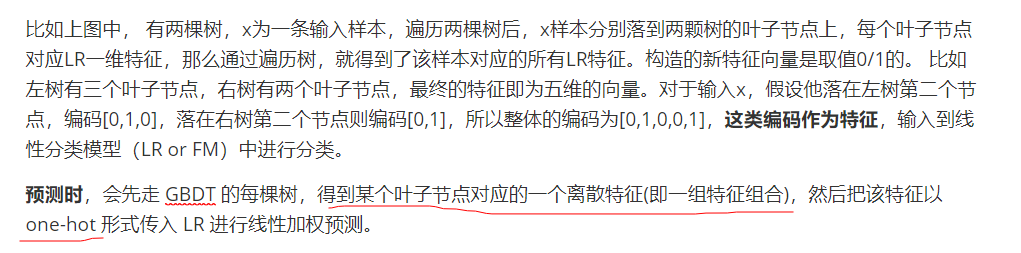

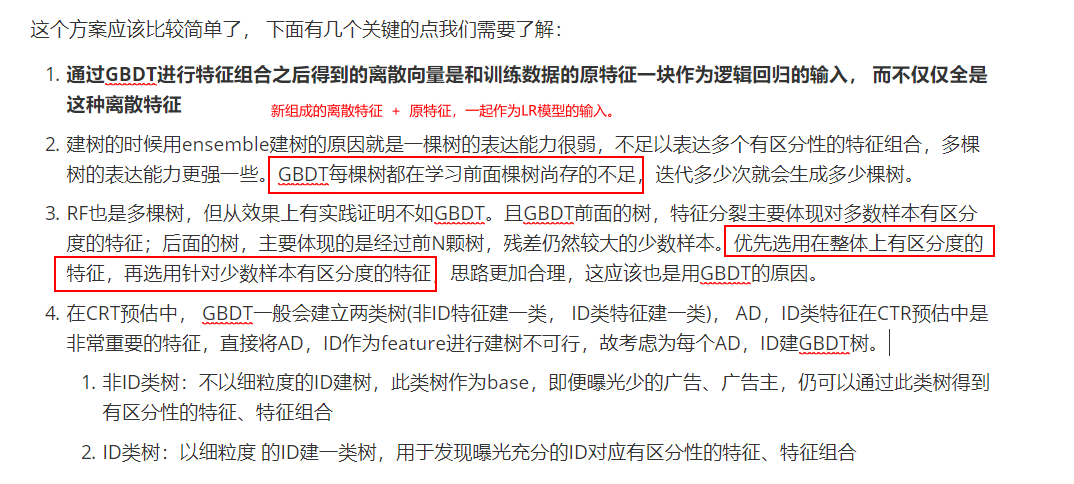

In [ ]:
## Description：
# 这个笔记本要做一个GBDT+LR的demon， 基于kaggle上的一个比赛数据集, 下载链接：[http://labs.criteo.com/2014/02/kaggle-display-advertising-challenge-dataset/](http://labs.criteo.com/2014/02/kaggle-display-advertising-challenge-dataset/) 数据集介绍：
# 这是criteo-Display Advertising Challenge比赛的部分数据集， 里面有train.csv和test.csv两个文件：
# * train.csv： 训练集由Criteo 7天内的部分流量组成。每一行对应一个由Criteo提供的显示广告。为了减少数据集的大小，正(点击)和负(未点击)的例子都以不同的比例进行了抽样。示例是按时间顺序排列的
# * test.csv: 测试集的计算方法与训练集相同，只是针对训练期之后一天的事件

# 字段说明：
# * Label： 目标变量， 0表示未点击， 1表示点击
# * l1-l13: 13列的数值特征， 大部分是计数特征
# * C1-C26: 26列分类特征， 为了达到匿名的目的， 这些特征的值离散成了32位的数据表示

# 这个比赛的任务就是：开发预测广告点击率(CTR)的模型。给定一个用户和他正在访问的页面，预测他点击给定广告的概率是多少？比赛的地址链接：[https://www.kaggle.com/c/criteo-display-ad-challenge/overview](https://www.kaggle.com/c/criteo-display-ad-challenge/overview)
# <br><br>
# 下面基于GBDT+LR模型完后这个任务。

In [28]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import log_loss
import gc
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [5]:
"""数据读取与预处理"""
# 数据读取
path = r'D:\MyData\chenpf8\Recommendation System\team-learning-rs\RecommendationSystemFundamentals\源代码\data/'
df_train = pd.read_csv(path + 'kaggle_train.csv')
df_test = pd.read_csv(path + 'kaggle_test.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      1599 non-null   int64  
 1   Label   1599 non-null   int64  
 2   I1      904 non-null    float64
 3   I2      1599 non-null   int64  
 4   I3      1242 non-null   float64
 5   I4      1265 non-null   float64
 6   I5      1525 non-null   float64
 7   I6      1207 non-null   float64
 8   I7      1522 non-null   float64
 9   I8      1597 non-null   float64
 10  I9      1522 non-null   float64
 11  I10     904 non-null    float64
 12  I11     1522 non-null   float64
 13  I12     361 non-null    float64
 14  I13     1265 non-null   float64
 15  C1      1599 non-null   object 
 16  C2      1599 non-null   object 
 17  C3      1553 non-null   object 
 18  C4      1553 non-null   object 
 19  C5      1599 non-null   object 
 20  C6      1402 non-null   object 
 21  C7      1599 non-null   object 
 22  

In [7]:
# 简单的数据预处理
# 去掉id列， 把测试集和训练集合并， 填充缺失值
df_train.drop(['Id'], axis=1, inplace=True)
df_test.drop(['Id'], axis=1, inplace=True)

In [8]:
df_train.shape, df_test.shape

((1599, 40), (400, 39))

In [9]:
df_test['Label'] = -1

data = pd.concat([df_train, df_test])
data.fillna(-1, inplace=True)

In [10]:
"""下面把特征列分开处理"""
continuous_fea = ['I'+str(i+1) for i in range(13)]
category_fea = ['C'+str(i+1) for i in range(26)]

In [11]:
## 建模
# 下面训练三个模型对数据进行预测， 分别是LR模型， GBDT模型和两者的组合模型， 然后分别观察它们的预测效果， 对于不同的模型， 特征会有不同的处理方式如下：
# 1. 逻辑回归模型： 连续特征要归一化处理， 离散特征需要one-hot处理
# 2. GBDT模型： 树模型连续特征不需要归一化处理， 但是离散特征需要one-hot处理
# 3. LR+GBDT模型： 由于LR使用的特征是GBDT的输出， 原数据依然是GBDT进行处理交叉， 所以只需要离散特征one-hot处理


In [14]:
data['I1'].values.reshape(-1, 1)[:10].shape  # reshap(-1,1) 把数据转为 n行（系统自动计算），1列

(10, 1)

In [20]:
# pd.get_dummies(data['I1'], prefix = 'I1')

pd.get_dummies??

In [15]:
# 下面就通过函数的方式建立三个模型， 并进行训练
### 逻辑回归建模
def lr_model(data, category_fea, continuous_fea):
    # 连续特征归一化
    scaler = MinMaxScaler()
    for col in continuous_fea:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    
    # 离散特征one-hot编码
    for col in category_fea:
        onehot_feats = pd.get_dummies(data[col], prefix=col)
        data.drop([col], axis=1, inplace=True)
        data = pd.concat([data, onehot_feats], axis=1)
    
    # 把训练集和测试集分开
    train = data[data['Label'] != -1]
    target = train.pop('Label')
    test = data[data['Label'] == -1]
    test.drop(['Label'], axis=1, inplace=True)
    
    # 划分数据集
    x_train, x_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=2021)
    
    # 建立模型
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    tr_logloss = log_loss(y_train, lr.predict_proba(x_train)[:, 1])   # −(ylog(p)+(1−y)log(1−p)) log_loss
    val_logloss = log_loss(y_val, lr.predict_proba(x_val)[:, 1])
    print('tr_logloss: ', tr_logloss)
    print('val_logloss: ', val_logloss)
    
    # 模型预测
    y_pred = lr.predict_proba(test)[:, 1]  # predict_proba 返回n行k列的矩阵，第i行第j列上的数值是模型预测第i个预测样本为某个标签的概率, 这里的1表示点击的概率
    print('predict: ', y_pred[:10]) # 这里看前10个， 预测为点击的概率


In [16]:
### GBDT 建模
def gbdt_model(data, category_fea, continuous_fea):
    
    # 离散特征one-hot编码
    for col in category_fea:
        onehot_feats = pd.get_dummies(data[col], prefix=col)
        data.drop([col], axis=1, inplace=True)
        data = pd.concat([data, onehot_feats], axis=1)
    
    # 训练集和测试集分开
    train = data[data['Label'] != -1]
    target = train.pop('Label')
    test = data[data['Label'] == -1]
    test.drop(['Label'], axis=1, inplace=True)
    
    # 划分数据集
    x_train, x_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=2021)
    
    # 建模
    gbm = lgb.LGBMClassifier(boosting_type='gbdt',  # 这里用gbdt
                             objective='binary', 
                             subsample=0.8,
                             min_child_weight=0.5, 
                             colsample_bytree=0.7,
                             num_leaves=100,
                             max_depth=12,
                             learning_rate=0.01,
                             n_estimators=10000
                            )
    gbm.fit(x_train, y_train, 
            eval_set=[(x_train, y_train), (x_val, y_val)], 
            eval_names=['train', 'val'],
            eval_metric='binary_logloss',
            early_stopping_rounds=100,
           )
    
    tr_logloss = log_loss(y_train, gbm.predict_proba(x_train)[:, 1])   # −(ylog(p)+(1−y)log(1−p)) log_loss
    val_logloss = log_loss(y_val, gbm.predict_proba(x_val)[:, 1])
    print('tr_logloss: ', tr_logloss)
    print('val_logloss: ', val_logloss)
    
    # 模型预测
    y_pred = gbm.predict_proba(test)[:, 1]  # predict_proba 返回n行k列的矩阵，第i行第j列上的数值是模型预测第i个预测样本为某个标签的概率, 这里的1表示点击的概率
    print('predict: ', y_pred[:10]) # 这里看前10个， 预测为点击的概率

In [47]:
### LR + GBDT建模
# 下面就是把上面两个模型进行组合， GBDT负责对各个特征进行交叉和组合， 把原始特征向量转换为新的离散型特征向量， 然后在使用逻辑回归模型
def gbdt_lr_model(data, category_feature, continuous_feature): # 0.43616
    # 离散特征one-hot编码
    for col in category_feature:
        onehot_feats = pd.get_dummies(data[col], prefix = col)
        data.drop([col], axis = 1, inplace = True)
        data = pd.concat([data, onehot_feats], axis = 1)

    train = data[data['Label'] != -1]
    target = train.pop('Label')
    test = data[data['Label'] == -1]
    test.drop(['Label'], axis = 1, inplace = True)

    # 划分数据集
    x_train, x_val, y_train, y_val = train_test_split(train, target, test_size = 0.2, random_state = 2020)

    gbm = lgb.LGBMClassifier(objective='binary',
                            subsample= 0.8,
                            min_child_weight= 0.5,
                            colsample_bytree= 0.7,
                            num_leaves=100,
                            max_depth = 12,
                            learning_rate=0.01,
                            n_estimators=1000,
                            )

    gbm.fit(x_train, y_train,
            eval_set = [(x_train, y_train), (x_val, y_val)],
            eval_names = ['train', 'val'],
            eval_metric = 'binary_logloss',
            early_stopping_rounds = 100,
            )
    
    model = gbm.booster_

    gbdt_feats_train = model.predict(train, pred_leaf = True)
    gbdt_feats_test = model.predict(test, pred_leaf = True)
#     print(train.shape,test.shape )   # (1599, 13104) (400, 13104)
#     print(gbdt_feats_train)
#     print("======")
#     print(gbdt_feats_test)
#     print("===++++++")
#     print(gbdt_feats_train.shape,gbdt_feats_test.shape )  # (1599, 147) (400, 147)
#     return train
    gbdt_feats_name = ['gbdt_leaf_' + str(i) for i in range(gbdt_feats_train.shape[1])]
    df_train_gbdt_feats = pd.DataFrame(gbdt_feats_train, columns = gbdt_feats_name) 
    df_test_gbdt_feats = pd.DataFrame(gbdt_feats_test, columns = gbdt_feats_name)

    train = pd.concat([train, df_train_gbdt_feats], axis = 1)
    test = pd.concat([test, df_test_gbdt_feats], axis = 1)
#     print(train.shape,test.shape )   # (1599, 13251) (400, 13251)
    train_len = train.shape[0]
    data = pd.concat([train, test])
    del train
    del test
    gc.collect()

    # # 连续特征归一化
    scaler = MinMaxScaler()
    for col in continuous_feature:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))

    for col in gbdt_feats_name:
        onehot_feats = pd.get_dummies(data[col], prefix = col)
        data.drop([col], axis = 1, inplace = True)
        data = pd.concat([data, onehot_feats], axis = 1)

    train = data[: train_len]
    test = data[train_len:]
#     print(train.shape,test.shape )  # (1599, 20046) (400, 20046)
    del data
    gc.collect()

    x_train, x_val, y_train, y_val = train_test_split(train, target, test_size = 0.3, random_state = 2018)

    
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    tr_logloss = log_loss(y_train, lr.predict_proba(x_train)[:, 1])
    print('tr-logloss: ', tr_logloss)
    val_logloss = log_loss(y_val, lr.predict_proba(x_val)[:, 1])
    print('val-logloss: ', val_logloss)
    y_pred = lr.predict_proba(test)[:, 1]
    print(y_pred[:10])
    return y_pred


In [48]:
y_pred = gbdt_lr_model(data.copy(), category_fea, continuous_fea)
y_pred

[1]	train's binary_logloss: 0.523857	val's binary_logloss: 0.457806
Training until validation scores don't improve for 100 rounds
[2]	train's binary_logloss: 0.521371	val's binary_logloss: 0.457213
[3]	train's binary_logloss: 0.519084	val's binary_logloss: 0.456616
[4]	train's binary_logloss: 0.516882	val's binary_logloss: 0.456046
[5]	train's binary_logloss: 0.514449	val's binary_logloss: 0.455649
[6]	train's binary_logloss: 0.512277	val's binary_logloss: 0.455319
[7]	train's binary_logloss: 0.509973	val's binary_logloss: 0.455039
[8]	train's binary_logloss: 0.507717	val's binary_logloss: 0.454523
[9]	train's binary_logloss: 0.505668	val's binary_logloss: 0.454546
[10]	train's binary_logloss: 0.503491	val's binary_logloss: 0.454134
[11]	train's binary_logloss: 0.501469	val's binary_logloss: 0.453151
[12]	train's binary_logloss: 0.499463	val's binary_logloss: 0.452609
[13]	train's binary_logloss: 0.497257	val's binary_logloss: 0.452419
[14]	train's binary_logloss: 0.495206	val's binary

[159]	train's binary_logloss: 0.321956	val's binary_logloss: 0.435101
[160]	train's binary_logloss: 0.321577	val's binary_logloss: 0.435013
[161]	train's binary_logloss: 0.321154	val's binary_logloss: 0.435011
[162]	train's binary_logloss: 0.32053	val's binary_logloss: 0.435055
[163]	train's binary_logloss: 0.320052	val's binary_logloss: 0.435117
[164]	train's binary_logloss: 0.319495	val's binary_logloss: 0.435364
[165]	train's binary_logloss: 0.318879	val's binary_logloss: 0.435365
[166]	train's binary_logloss: 0.318222	val's binary_logloss: 0.435419
[167]	train's binary_logloss: 0.317357	val's binary_logloss: 0.435392
[168]	train's binary_logloss: 0.316691	val's binary_logloss: 0.435438
[169]	train's binary_logloss: 0.316256	val's binary_logloss: 0.435394
[170]	train's binary_logloss: 0.315882	val's binary_logloss: 0.435375
[171]	train's binary_logloss: 0.315545	val's binary_logloss: 0.435288
[172]	train's binary_logloss: 0.314797	val's binary_logloss: 0.435324
[173]	train's binary_

array([9.42504639e-01, 2.76597656e-01, 2.27699953e-02, 1.86025096e-02,
       4.45934326e-03, 6.48474724e-01, 6.80003741e-03, 3.57831915e-03,
       4.16062509e-04, 5.44962925e-02, 5.01633860e-03, 1.29855613e-03,
       2.39149123e-01, 2.03711710e-02, 8.64941449e-02, 4.71376176e-04,
       2.47398116e-03, 3.27303630e-03, 6.03381176e-03, 3.15074745e-03,
       3.92769401e-03, 1.78960879e-03, 1.43287278e-02, 2.26289911e-02,
       4.39282093e-03, 1.93882101e-01, 8.20411441e-03, 7.05994379e-02,
       2.87308929e-01, 2.56756721e-02, 1.81921688e-03, 3.61057715e-03,
       1.18922710e-02, 9.74040145e-04, 1.80507101e-01, 9.68848614e-03,
       5.58602911e-03, 5.63475458e-03, 6.93977410e-02, 7.14722437e-01,
       1.55421164e-02, 4.76581194e-01, 5.13365607e-01, 6.41754234e-02,
       5.78048427e-03, 3.84770037e-02, 1.14917034e-03, 2.09664814e-01,
       5.92025565e-01, 3.50519799e-03, 2.33182867e-01, 3.11156201e-03,
       4.75212173e-01, 1.18393729e-02, 1.73641767e-01, 9.77597601e-03,
      

In [34]:
pd.DataFrame(gbdt_feats_train)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99   100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146
0      12   12   30    6    5    5   14   13    5   13   21   10    8   12   11   13   16    1   13    8    8   19   25   31   40    3   14    8    8   21    7    8   13   16    8    7    7   25   12    1    3   24   10   17   13   24    3   27    3    3   20   17   27   14   34   22    3    1    3   26    9    7   17    2    9   30   21   25    4   23   31   11    3   26   38   19    3    6   20    5    4   31   26   14    0    7   21    6   19   26    7    2    9    6    8    1    5   20    4    1    9    2   13   28   34    6   10   21   21   16    5   25    2   28   23    4    4   19    4    0   16    4   15    2    4   16    8   35    4    0    6   15   33   17   22   10   25   15   16    6    3   40   17   10   16   11   16
1      12    7   29   19    9    1   14    1   15    1   13   33   23   15    1   24   20   12   17   17    1   15   44   12   40    1   39    1   20   14   11   17    1   17   13   10    8   24   12   14   23    1   30   28    8   13   21    9   44   22   15   13   23   41   22   11   22    1   12   21    7    1   10   22   28   17   33   12   18    0   32   24   26   36   17    6   25   20   15    9   21   14   29   20    0   27   29   20   42   12   23   31   40   20   31   30   28   13   18   44   34   27   22   32   35   20   19   16    0    7   19   28   36    0    0   34   29   21   24   26   39   19    0   27    0    0    0   40   17   30    0   19   39   21   30    0   34   14   21   27    0   28   26    0   33    0   26
2      36   37   35   25   34   22   34   43   17   43    2   16   42   20   36   19   30   29   46   41   33   31   40   32    2   30   35   16   38   34   18   42   20   11   33   21   30   13   35    2   17    7   17   20   29   16   35   26    2   30    7    2   17   23    2   26    2    2    1   33   25   36   10   15    0   41    7    0    0   26   19   45   10   27   27   36   16   30    8   41   27   32    5    6    0   32   24   27   39   22   34   36   42   12   31   37   28   16   22   38   39   16   22   33   37   37   30   26    0    7   23    7   29   28    0   46    8   37   24   20   39   24   13   42    0   26   12   35   10   30    0   18   40   24   24   23   36   41   16   14   16   30   15   12   25   10   17
3      23   43   15   30   38   14   24   13   25   13   30   21   46   25   11   14   36    8   45   28   22   20   31   23   28   11   23   21   17   19   22   41   31   14   22   24   40   22    6    7   33   37   24   26   10   34   43   13   38   12   22   27   12   28   24   21   39   17   17    1    8   42   19   35   26   13   11   26   46   17   17   10   17   17    9   27   18   32   33   12   46   18   19   19   18   33   12   45   13   33   33   26   26   34   12   13   33   11   14   27   26    9   27   38   10   24   27   21   37   14   14    8   33   18   32   13   17   17   34   29   42   13   25   12   19    7    9   28    9   31    0   26   26   12   16   23   16   31   13   44   39   23   13   31   22   23   25
4      33   10    7   11    8    2   32   32   12   32    7    2    2   10   14   15   33   25   10    2   14   30    6    2   10   17   11   11   11    2   14    2   37   19   36   13    2   15    9   12    6   21    6   10   16   12   25    8   18    3   11    1   18    9   10   38    6   13    9    5  

In [52]:
y_pred

array([9.42504639e-01, 2.76597656e-01, 2.27699953e-02, 1.86025096e-02,
       4.45934326e-03, 6.48474724e-01, 6.80003741e-03, 3.57831915e-03,
       4.16062509e-04, 5.44962925e-02, 5.01633860e-03, 1.29855613e-03,
       2.39149123e-01, 2.03711710e-02, 8.64941449e-02, 4.71376176e-04,
       2.47398116e-03, 3.27303630e-03, 6.03381176e-03, 3.15074745e-03,
       3.92769401e-03, 1.78960879e-03, 1.43287278e-02, 2.26289911e-02,
       4.39282093e-03, 1.93882101e-01, 8.20411441e-03, 7.05994379e-02,
       2.87308929e-01, 2.56756721e-02, 1.81921688e-03, 3.61057715e-03,
       1.18922710e-02, 9.74040145e-04, 1.80507101e-01, 9.68848614e-03,
       5.58602911e-03, 5.63475458e-03, 6.93977410e-02, 7.14722437e-01,
       1.55421164e-02, 4.76581194e-01, 5.13365607e-01, 6.41754234e-02,
       5.78048427e-03, 3.84770037e-02, 1.14917034e-03, 2.09664814e-01,
       5.92025565e-01, 3.50519799e-03, 2.33182867e-01, 3.11156201e-03,
       4.75212173e-01, 1.18393729e-02, 1.73641767e-01, 9.77597601e-03,
      

In [54]:
df_test = pd.read_csv(path + 'kaggle_test.csv')
df_test

Id   I1    I2    I3    I4       I5     I6    I7    I8     I9  I10  I11  I12   I13        C1        C2        C3        C4        C5        C6        C7        C8        C9       C10       C11       C12       C13       C14       C15       C16       C17       C18       C19       C20       C21       C22       C23       C24       C25       C26
0    10000405  NaN    -1   NaN   NaN   8020.0   26.0   6.0   0.0   80.0  NaN  2.0  NaN   NaN  8cf07265  b80912da  e51edcbe  90f40919  25c83c98  6f6d9be8  59434e5e  1f89b562  a73ee510  3b08e48b  a04db730  b57ec450  c66b30f8  07d13a8f  569913cf  11fe787a  e5ba7672  7119e567  1d04f4a4  b1252a9d  d5f54153       NaN  32c7478e  a9d771cd  c9f3bea7  0a47000d
1    10001189  NaN    -1   NaN   NaN  17881.0    9.0   8.0   0.0    0.0  NaN  1.0  0.0   NaN  05db9164  bf7a2333  210c632d  3d513154  0942e0a7       NaN  b87f4a4a  0b153874  a73ee510  b8b81ee6  319687c9  8747d4c8  62036f49  07d13a8f  9a0b7e16  d58d490f  e5ba7672  51369abb       NaN       NaN  d4b6b7e8       NaN  32c7478e  37821b83       NaN       NaN
2    10000674  0.0     0   2.0  13.0   2904.0  104.0   1.0   3.0  100.0  0.0  1.0  NaN  13.0  1464facd  8947f767  9d56d2c7  68fb546c  43b19349  fbad5c96  d20b4953  1f89b562  a73ee510  fbbf2c95  b5a9f90e  edf66ca8  949ea585  f7c1b33f  7f758956  b78548fb  e5ba7672  bd17c3da  966f1c31  a458ea53  1d1393f4  ad3062eb  32c7478e  3fdb382b  010f6491  49d68486
3    10001358  0.0  1471  51.0   4.0   1573.0   63.0   1.0   4.0   13.0  0.0  1.0  NaN   4.0  68fd1e64  80e26c9b  9e471be4  169ffff5  4cf72387  7e0ccccf  6772d022  5b392875  a73ee510  213fd432  962f47a7  3ef5350b  e8df3343  07d13a8f  02319a52  f294bed7  d4bb7bd8  1f9656b8  21ddcdc9  b1252a9d  602ce342       NaN  3a171ecb  1793a828  e8b83407  70b6702c
4    10000810  0.0    16   9.0  17.0   2972.0  621.0  13.0  42.0  564.0  0.0  2.0  0.0  17.0  68fd1e64  08d6d899  a2edc244  60d5f5a7  25c83c98  7e0ccccf  89376183  5b392875  a73ee510  24691f45  8bd4b780  bde06ba1  c0bff1ae  07d13a8f  1a277242  b93ac0ad  e5ba7672  87c6f83c       NaN       NaN  bf8efd4c  c9d4222a  423fab69  f96a556f       NaN       NaN
..        ...  ...   ...   ...   ...      ...    ...   ...   ...    ...  ...  ...  ...   ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
395  10001453  1.0     0   1.0   NaN    149.0    5.0   1.0   0.0    0.0  1.0  1.0  NaN   NaN  be589b51  09e68b86  d01261c6  d551fbe0  25c83c98  7e0ccccf  25504ca6  0b153874  a73ee510  3b08e48b  661c2800  9449c78e  38087489  07d13a8f  36721ddc  5fed0876  d4bb7bd8  5aed7436  d16737e3  a458ea53  edc49a33       NaN  93bad2c0  3fdb382b  e8b83407  80dd0a5b
396  10000360  NaN    -1   NaN   NaN      NaN    NaN   0.0   0.0    6.0  NaN  0.0  NaN   NaN  05db9164  b961056b  d1b59691  8eb681c0  25c83c98       NaN  88002ee1  5b392875  7cc72ec2  3b08e48b  f1b78ab4  0826f297  6e5da64f  1adce6ef  4903dd2e  0abe22ad  2005abd1  5162930e       NaN       NaN  12965bb8       NaN  32c7478e  71292dbb       NaN       NaN
397  10001809  0.0   300   4.0   NaN   4622.0   25.0  20.0   6.0   55.0  0.0  2.0  4.0   NaN  68fd1e64  403ea497  2cbec47f  3e2bfbda  25c83c98  fe6b92e5  197b4575  0b153874  a73ee510  6c47047a  606866a9  21a23bfe  e40e52ae  07d13a8f  e3209fc2  587267a3  8efede7f  a78bd508  21ddcdc9  5840adea  c2a93b37       NaN  3a171ecb  1793a828  e8b83407  2fede552
398  10000769  1.0     1   2.0   1.0      5.0    1.0   1.0   1.0    1.0  1.0  1.0  NaN   1.0  05db9164  ea3a5818  828ef18f  ba229df2  384874ce  7e0ccccf  969e0f2f  0b153874  a73ee510  fa7d0797  9163f8f1  eac9feed  b5b29c1f  1adce6ef  7e7dc5e4  98a54621  d4bb7bd8  a1d0cc4f  c68db44a  a458ea53  3b1ae854       NaN  32c7478e  57e2c6c9  1575c75f  7132fed8
399  10000563  NaN     2   NaN   NaN  36144.0    NaN   NaN  36.0    NaN  NaN  NaN  NaN   NaN  05db9164  d833535f  77f2f2e5  d166

In [55]:
submit = pd.DataFrame()
submit['Id'] = df_test['Id']
submit['Predicted'] = y_pred
submit

Id  Predicted
0    10000405   0.942505
1    10001189   0.276598
2    10000674   0.022770
3    10001358   0.018603
4    10000810   0.004459
..        ...        ...
395  10001453   0.117408
396  10000360   0.189874
397  10001809   0.022919
398  10000769   0.102195
399  10000563   0.003618

[400 rows x 2 columns]

In [58]:
submit.to_csv('my_submit.csv',encoding='utf-8',index=False)